# Gastos por Categoría 2025

In [73]:
import sys

# Añadimos al path la ruta del código fuente para poder usar
# la conexión a la base de datos
sys.path.append('../src')
from db.connection import ConexionBD

import pandas as pd
import os

import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
from scipy import stats

%matplotlib inline

In [74]:
conn = ConexionBD.obtener_conexion()

In [75]:
# Gastos 2025
query = """
    SELECT fecha_valor, importe, saldo, categoria, subcategoria, descripcion
    FROM bancapp.movimientos_mview
    WHERE fecha_valor >= '2025-01-01'
    ORDER BY fecha_valor
    """

results =  conn.execute(query).fetchall()
df = pd.DataFrame(results)
                 
# Convierte múltiples columnas a numérico; si encuentra basura, pone NaN
cols_numericas = ['importe', 'saldo']
df[cols_numericas] = df[cols_numericas].apply(pd.to_numeric, errors='coerce')

# Convierte a fecha
df['fecha_valor'] = pd.to_datetime(df['fecha_valor'])
df['mes_valor'] = df["fecha_valor"].dt.month
df['anio_valor'] = df["fecha_valor"].dt.year

# Creamos el data frame de gastos
df_gastos = df[df.importe<0][["fecha_valor","mes_valor","anio_valor", "importe", "categoria", 
                              "subcategoria", "descripcion"]]
df_gastos["importe"] = df_gastos["importe"].apply(abs)

# Creamos categorias
df_gastos["categoria"] = df_gastos["categoria"].astype("category")
df_gastos["subcategoria"] = df_gastos["subcategoria"].astype("category") 

# Quitamos los gastos de la obra de los baños
df_gastos = df_gastos[df_gastos.importe < 2000]

df_gastos.info()

<class 'pandas.core.frame.DataFrame'>
Index: 665 entries, 0 to 768
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   fecha_valor   665 non-null    datetime64[ns]
 1   mes_valor     665 non-null    int32         
 2   anio_valor    665 non-null    int32         
 3   importe       665 non-null    float64       
 4   categoria     665 non-null    category      
 5   subcategoria  665 non-null    category      
 6   descripcion   665 non-null    object        
dtypes: category(2), datetime64[ns](1), float64(1), int32(2), object(1)
memory usage: 28.9+ KB


In [76]:
df_gastos.info()

<class 'pandas.core.frame.DataFrame'>
Index: 665 entries, 0 to 768
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   fecha_valor   665 non-null    datetime64[ns]
 1   mes_valor     665 non-null    int32         
 2   anio_valor    665 non-null    int32         
 3   importe       665 non-null    float64       
 4   categoria     665 non-null    category      
 5   subcategoria  665 non-null    category      
 6   descripcion   665 non-null    object        
dtypes: category(2), datetime64[ns](1), float64(1), int32(2), object(1)
memory usage: 28.9+ KB


**Media de gasto mensual**

In [77]:
dfg = df_gastos.groupby("mes_valor").agg(total=("importe","sum"))

media_mensual = dfg.total.mean()

print(f"Gasto medio mensual: {media_mensual:.2f}")

Gasto medio mensual: 3728.42


**Gasto medio mensual por categoria**

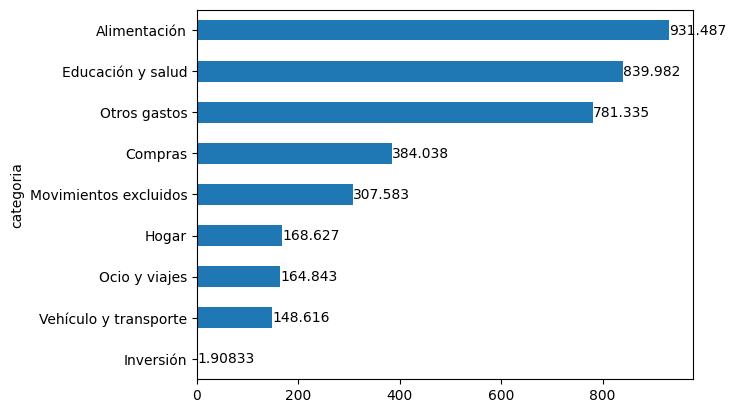

In [96]:
dfg = df_gastos.groupby(["mes_valor","categoria"], observed=True).agg(total=("importe","sum"))
pivot = dfg.total.unstack(fill_value=0)
ax = pivot.mean().sort_values().plot(kind="barh");
ax.bar_label(ax.containers[0]);

**Listado de categorías**

In [52]:
df_gastos.categoria.cat.categories

Index(['Alimentación', 'Compras', 'Educación y salud', 'Hogar', 'Inversión',
       'Movimientos excluidos', 'Ocio y viajes', 'Otros gastos',
       'Vehículo y transporte'],
      dtype='object')

**Gastos por categoría**

Agrupamnos por categoria

In [67]:
dfg = df_gastos.groupby("categoria",observed=True).agg(total=("importe","sum"))

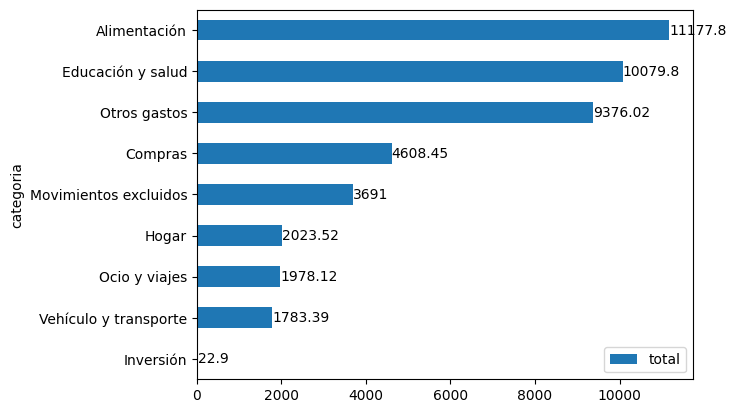

In [68]:
ax = dfg.sort_values(by="total").plot(kind="barh")
ax.bar_label(ax.containers[0]);

**Gasto mensual por categoría**

In [56]:
# Función reutilizable por categoría
def gasto_mes_categoria(categoria:str):

    dfg = df_gastos[df_gastos.categoria==categoria].groupby("mes_valor").agg(total=("importe","sum"))

    #calculate mean
    mean_val = dfg.total.mean()

    # Plot the group
    ax = dfg.plot(kind="bar");
    
    # Plot Línea de media
    ax.axhline(y=mean_val, color="red", label=f'Media: {mean_val:.0f}');
    
    # Plot Etiquetas dee las barras
    ax.bar_label(ax.containers[0]);
    
    plt.title(f"Gasto {categoria} por mes 2025")
    plt.legend()
    plt.show()

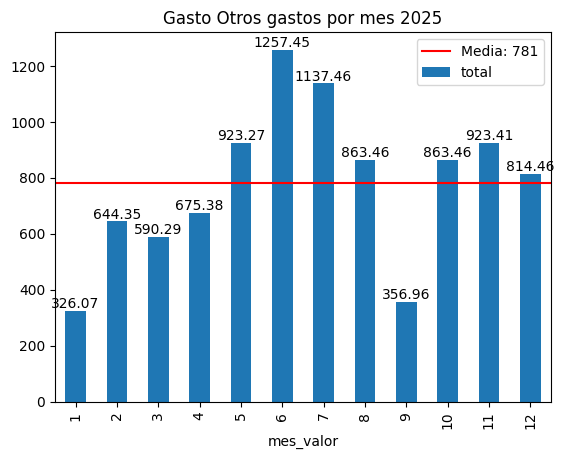

In [57]:
gasto_mes_categoria("Otros gastos")

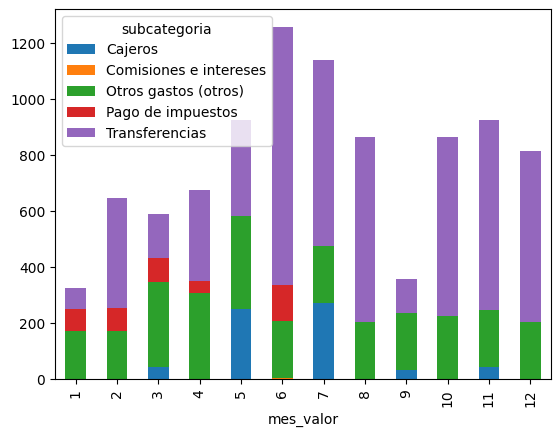

In [62]:
dfg = df_gastos[df_gastos.categoria=="Otros gastos"] \
    .groupby(["mes_valor", "subcategoria"], observed=True) \
    .agg(total=("importe","sum"))

pivot = dfg.total.unstack(fill_value=0)

pivot.plot(kind="bar", stacked=True);

In [63]:
df_gastos.subcategoria.cat.categories

Index(['Agua', 'Belleza, peluquería y perfumería', 'Cafeterías y restaurantes',
       'Cajeros', 'Cine, teatro y espectáculos', 'Comisiones e intereses',
       'Compras (otros)', 'Decoración y mobiliario', 'Dentista, médico',
       'Deporte y gimnasio', 'Educación', 'Electrónica',
       'Farmacia, herbolario y nutrición', 'Fondos de inversión',
       'Gasolina y combustible', 'Hotel y alojamiento',
       'Libros, música y videojuegos', 'Luz y gas', 'Mantenimiento del hogar',
       'Ocio y viajes (otros)', 'Otros gastos (otros)', 'Pago de impuestos',
       'Parking y garaje', 'Peajes', 'Regalos y juguetes',
       'Ropa y complementos', 'Seguro de coche y moto',
       'Supermercados y alimentación', 'Teléfono, TV e internet',
       'Transferencias', 'Traspaso entre cuentas'],
      dtype='object')

In [66]:
df_gastos[(df_gastos.categoria=="Otros gastos") & (df_gastos.subcategoria=="Transferencias")] \
    .sort_values(by="importe", ascending=False)

,fecha_valor,mes_valor,anio_valor,importe,categoria,subcategoria,descripcion
622,2025-11-03,11,2025,462.0,Otros gastos,Transferencias,Transferencia emitida a CARLOS ANTONIO PEREZ H...
455,2025-08-07,8,2025,450.0,Otros gastos,Transferencias,Transferencia emitida a MCARMEN LOPEZ GUIJARRO...
387,2025-07-03,7,2025,429.0,Otros gastos,Transferencias,Transferencia emitida a CARLOS ANTONIO PEREZ H...
377,2025-06-30,6,2025,400.0,Otros gastos,Transferencias,Transferencia emitida a CDE RANDORI CUOTA Manu...
571,2025-10-07,10,2025,400.0,Otros gastos,Transferencias,Transferencia emitida a CARLOS ANTONIO PEREZ H...
699,2025-12-06,12,2025,396.0,Otros gastos,Transferencias,Transferencia emitida a CARLOS ANTONIO PEREZ H...
302,2025-05-27,5,2025,265.0,Otros gastos,Transferencias,Transferencia emitida a CDE RANDORI Cuota Alej...
103,2025-02-28,2,2025,263.0,Otros gastos,Transferencias,Transferencia emitida a EDY ISABEL MONTOYA MOR...
322,2025-06-03,6,2025,237.0,Otros gastos,Transferencias,Transferencia emitida a CARMEN LOPEZ GUIJARRO ...
635,2025-11-05,11,2025,140.0,Otros gastos,Transferencias,Transferencia emitida a PSICOLOGIA Y LOGOPEDIA...


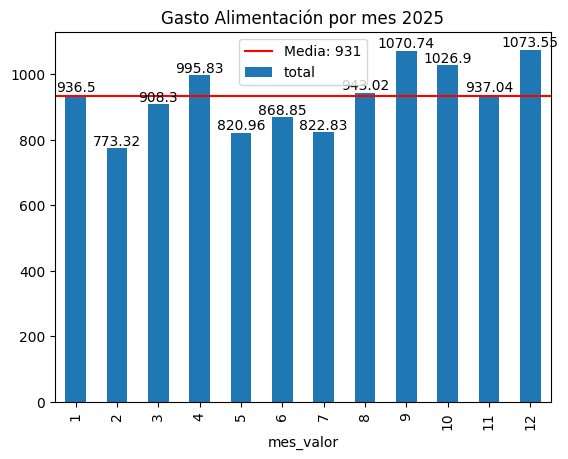

In [9]:
gasto_mes_categoria("Alimentación")

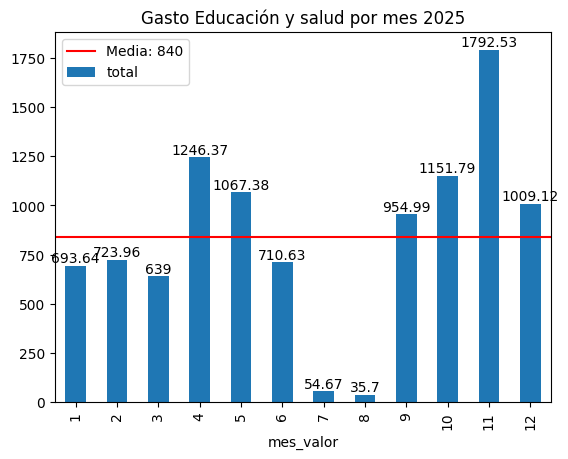

In [10]:
gasto_mes_categoria("Educación y salud")

Revisar gastos de noviembre

In [11]:
df_gastos[(df_gastos.categoria=="Educación y salud") & (df_gastos.mes_valor==11)].sort_values(by="importe", ascending=False)

,fecha_valor,mes_valor,anio_valor,importe,categoria,subcategoria,descripcion
623,2025-11-03,11,2025,404.13,Educación y salud,Educación,Recibo SERVICIOS EDUCATIVOS EL VALLE DE SANCHI...
624,2025-11-03,11,2025,398.40,Educación y salud,Educación,Recibo SERVICIOS EDUCATIVOS EL VALLE DE SAN CHI
634,2025-11-05,11,2025,347.00,Educación y salud,Deporte y gimnasio,Pago en C.D.E.V. Sanchinarro MARIA TUBAU ES
633,2025-11-05,11,2025,347.00,Educación y salud,Deporte y gimnasio,Pago en C.D.E.V. Sanchinarro MARIA TUBAU ES
648,2025-11-11,11,2025,200.00,Educación y salud,"Dentista, médico",Pago en CLINICA BLASCO IBA¥EZ MADRID ES
619,2025-11-02,11,2025,45.00,Educación y salud,Deporte y gimnasio,Pago en C.D.E.V. SANCHINARRO MADRID ES
618,2025-11-02,11,2025,45.00,Educación y salud,Deporte y gimnasio,Pago en C.D.E.V. SANCHINARRO MADRID ES
676,2025-11-27,11,2025,6.00,Educación y salud,Educación,Pago en COLEGIO EL VALLE SANCHINAMADRID ES


Agrupamos por subcategoría y pivotamos para revisar visualemente

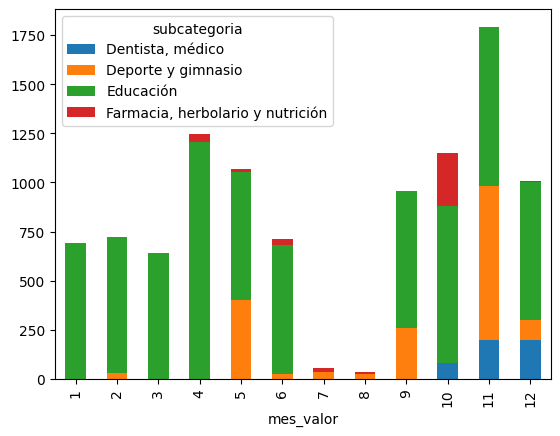

In [12]:
# Agrupamos por mes y subcategoria
dfg = df_gastos[df_gastos.categoria=="Educación y salud"].groupby(["mes_valor", "subcategoria"]).agg(total=("importe","sum"))

# Obtenemos la seria, que tiene multi-index (mes y subcategoria) y pivotamos por subcategoria, para llevarlo a columnas y poder apilar
dfg_pivot = dfg["total"].unstack().fillna(0)

dfg_pivot.plot(kind="bar", stacked=True)

plt.show()

**Compras**

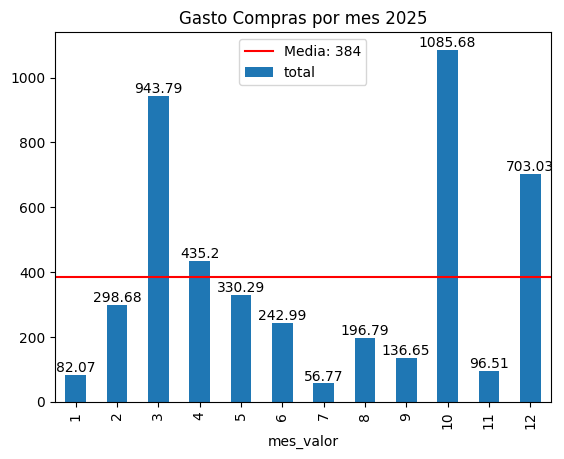

In [13]:
gasto_mes_categoria("Compras")

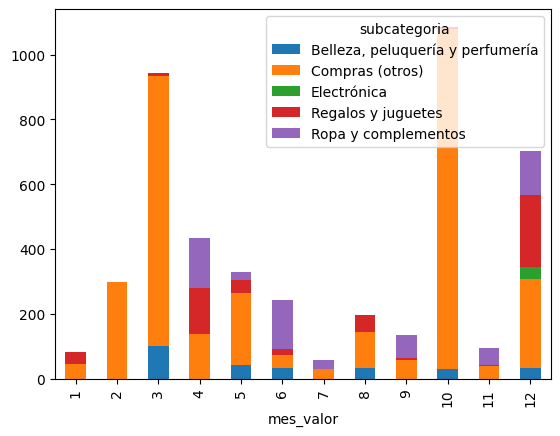

In [14]:
dfg = df_gastos[df_gastos.categoria=="Compras"].groupby(["mes_valor", "subcategoria"]).agg(total=("importe","sum"))
pivot = dfg["total"].unstack(fill_value=0)

ax = pivot.plot(kind="bar", stacked=True)

Revisamos las compras de octubre

In [15]:
df_gastos[(df_gastos.categoria=="Compras") & (df_gastos.mes_valor==10)].sort_values(by="importe", ascending=False)

,fecha_valor,mes_valor,anio_valor,importe,categoria,subcategoria,descripcion
594,2025-10-22,10,2025,774.25,Compras,Compras (otros),Pago en MOGACAR PV FUENCARRAL FUENCARRAL ES
598,2025-10-23,10,2025,195.73,Compras,Compras (otros),Pago en AYTO MADRID PAGO INTERNETMADRID ES
578,2025-10-11,10,2025,56.90,Compras,Compras (otros),Pago en EL CORTE INGLES SANCHINARMADRID ES
565,2025-10-03,10,2025,29.51,Compras,"Belleza, peluquería y perfumería",Pago en MI PELU MADRID ES
573,2025-10-07,10,2025,22.49,Compras,Compras (otros),Pago en AMAZON* V80Q52FJ5
570,2025-10-05,10,2025,6.80,Compras,Regalos y juguetes,Pago en BAZAR LONG MADRID ES
